In [1]:
import gym
import numpy as np

import tensorflow as tf
import tensorflow.contrib.distributions as dist
import tensorflow.contrib.layers as layers

import matplotlib.pyplot as plt



In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

tf.set_random_seed(2019)
np.random.seed(2019)

<h2>Create Environments</h2>

In [3]:
from common.multiprocessing_env import SubprocVecEnv

num_envs = 16
env_name = "Pendulum-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

<h2>Neural Network</h2>

In [4]:
class ActorCritic:
    def __init__(self, sess, obs, acs, hidden_size, name, trainable, init_std=1.0):
        self.sess = sess
        self.obs = obs
        self.acs = acs
        self.hidden_size = hidden_size
        self.name = name
        self.trainable = trainable
        self.init_std = init_std

        self.num_ac = self.acs.get_shape().as_list()[-1]

        with tf.variable_scope(name):
            self._build_network()

    def _build_network(self):
        with tf.variable_scope('critic'):
            c_h1 = layers.fully_connected(self.obs, self.hidden_size, trainable=self.trainable)
            c_out = layers.fully_connected(c_h1, 1, activation_fn=None, trainable=self.trainable)

        with tf.variable_scope('actor'):
            a_h1 = layers.fully_connected(self.obs, self.hidden_size, trainable=self.trainable)
            a_out = layers.fully_connected(a_h1, self.num_ac, activation_fn=None, trainable=self.trainable)

            log_std = tf.get_variable('log_std', [1, self.num_ac], dtype=tf.float32,
                                      initializer=tf.constant_initializer(self.init_std),
                                      trainable=self.trainable)

        std = tf.exp(log_std)
        a_dist = dist.Normal(a_out, std)
        self.log_prob = a_dist.log_prob(self.acs)
        self.entropy = tf.reduce_mean(a_dist.entropy())

        self.value = tf.identity(c_out)
        self.action = a_dist.sample()

    def params(self):
        return tf.global_variables(self.name).copy()

<h2>GAE</h2>

In [5]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

<h2>Proximal Policy Optimization Algorithm</h2>

In [6]:
class PPO:
    def __init__(self, sess, ob_shape, ac_shape, lr, hidden_size, eps=0.2, v_coeff=0.5, ent_coeff=0.01):
        self.sess = sess
        self.ob_shape = ob_shape
        self.ac_shape = ac_shape
        self.lr = lr
        self.hidden_size = hidden_size
        self.eps = eps
        self.v_coeff = v_coeff
        self.ent_coeff = ent_coeff

        self._create_ppo_graph()

    def _create_ppo_graph(self):
        self.obs = tf.placeholder(dtype=tf.float32, shape=[None] + self.ob_shape, name='observation')
        self.acs = tf.placeholder(dtype=tf.float32, shape=[None] + self.ac_shape, name='action')
        self.returns = tf.placeholder(dtype=tf.float32, shape=[None, 1])
        self.advs = tf.placeholder(dtype=tf.float32, shape=[None, 1])

        self.pi = ActorCritic(self.sess, self.obs, self.acs, self.hidden_size, 'new_pi', trainable=True)
        self.old_pi = ActorCritic(self.sess, self.obs, self.acs, self.hidden_size, 'old_pi', trainable=False)

        self.pi_param = self.pi.params()
        self.old_pi_param = self.old_pi.params()

        with tf.name_scope('update_old_policy'):
            self.oldpi_update = [oldp.assign(p) for p, oldp in zip(self.pi_param, self.old_pi_param)]

        with tf.name_scope('loss'):
            ratio = tf.exp(self.pi.log_prob - self.old_pi.log_prob)
            surr = ratio * self.advs
            self.actor_loss = tf.reduce_mean(
                tf.minimum(surr, tf.clip_by_value(ratio, 1 - self.eps, 1 + self.eps) * self.advs))
            self.critic_loss = tf.reduce_mean(tf.square(self.returns - self.pi.value))

            self.loss = (- self.actor_loss - self.ent_coeff * tf.reduce_mean(self.pi.entropy)
                         + self.v_coeff * self.critic_loss)

            with tf.variable_scope('train_op'):
                grads = tf.gradients(self.loss, self.pi_param)
                self.grads = list(zip(grads, self.pi_param))
                self.train_op = tf.train.AdamOptimizer(self.lr).apply_gradients(self.grads)
                                                                                #global_step=self.global_step)

    def get_action(self, obs):
        return self.sess.run(self.pi.action, feed_dict={self.obs: obs})

    def get_value(self, obs):
        return self.sess.run(self.pi.value, feed_dict={self.obs: obs})

    def assign_old_pi(self):
        self.sess.run(self.oldpi_update)

    def update(self, obs, acs, returns, advs):
        feed_dict = {self.obs: obs,
                     self.acs: acs,
                     self.returns: returns,
                     self.advs: advs
                     }

        self.sess.run(self.train_op, feed_dict=feed_dict)

In [7]:
def ppo_iter(mini_batch_size, obs, acs, returns, advantage):
    batch_size = obs.shape[0]
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield (obs[rand_ids, :], acs[rand_ids, :],
               returns[rand_ids, :], advantage[rand_ids, :])

<h2>Testing Function</h2>

In [8]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(model, vis=False):
    ob = env.reset()
    done = False
    total_reward = 0
    while not done:
        if vis:
            env.render()
        ac = model.get_action([ob])[0]
        next_ob, reward, done, _ = env.step(ac)
        ob = next_ob
        total_reward += reward
    return total_reward

<h2>Hyperparameters</h2>

In [9]:
hidden_size = 256
lr = 3e-4
num_steps = 20
mini_batch_size = 5
ppo_epochs = 4
threshold_reward = -200

max_frames = 15000
frame_idx  = 0
test_rewards = []

<h2>Training</h2>

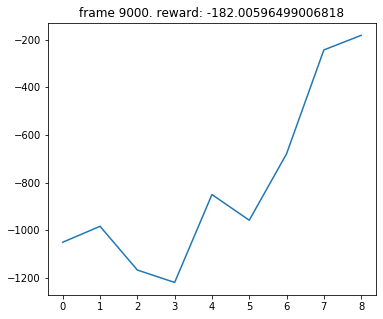

In [10]:
ob_shape = list(envs.observation_space.shape)
ac_shape = list(envs.action_space.shape)

ob = envs.reset()
early_stop = False

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)
ppo = PPO(sess, ob_shape, ac_shape, lr, hidden_size)

sess.run(tf.global_variables_initializer())

while frame_idx < max_frames and not early_stop:

    log_probs = []
    values = []
    obs = []
    acs = []
    rewards = []
    masks = []
    entropy = 0

    for _ in range(num_steps):

        ac = ppo.get_action(ob)
        next_ob, reward, done, _ = envs.step(ac)

        value = ppo.get_value(ob)
        values.append(value)
        rewards.append(reward[:, np.newaxis])
        masks.append((1-done)[:, np.newaxis])

        obs.append(ob)
        acs.append(ac)

        ob = next_ob
        frame_idx += 1

        if frame_idx % 1000 == 0:
            test_reward = np.mean([test_env(ppo) for _ in range(10)])
            test_rewards.append(test_reward)
            plot(frame_idx, test_rewards)
            if test_reward > threshold_reward: early_stop = True

    next_value = ppo.get_value(next_ob)
    returns = compute_gae(next_value, rewards, masks, values)

    returns = np.concatenate(returns)
    values = np.concatenate(values)
    obs = np.concatenate(obs)
    acs = np.concatenate(acs)
    advantages = returns - values

    ppo.assign_old_pi()
    for _ in range(ppo_epochs):
        for ob_batch, ac_batch, return_batch, adv_batch in ppo_iter(mini_batch_size, obs, acs, returns, advantages):
            ppo.update(ob_batch, ac_batch, return_batch, adv_batch)

In [11]:
from itertools import count

max_expert_num = 50000
num_steps = 0
expert_traj = []

for i_episode in count():
    ob = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        ac = ppo.get_action([ob])[0]
        next_ob, reward, done, _ = env.step(ac)
        ob = next_ob
        total_reward += reward
        expert_traj.append(np.hstack([ob, ac]))
        num_steps += 1
    
    print("episode:", i_episode, "reward:", total_reward)
    
    if num_steps >= max_expert_num:
        break
        
expert_traj = np.stack(expert_traj)
print()
print(expert_traj.shape)
print()
np.save("expert_traj.npy", expert_traj)

episode: 0 reward: -246.7083191744881
episode: 1 reward: -253.23816676152242
episode: 2 reward: -5.700545703579701
episode: 3 reward: -134.0083425356645
episode: 4 reward: -4.051806843136793
episode: 5 reward: -133.4349354178555
episode: 6 reward: -250.64500114689358
episode: 7 reward: -134.59654080910602
episode: 8 reward: -126.93592056346755
episode: 9 reward: -238.48087818961002
episode: 10 reward: -125.94405152664496
episode: 11 reward: -880.426643291184
episode: 12 reward: -984.9207227420158
episode: 13 reward: -7.447175281558876
episode: 14 reward: -132.81241822739992
episode: 15 reward: -334.3019648738332
episode: 16 reward: -124.14344277851467
episode: 17 reward: -263.15693693385225
episode: 18 reward: -125.04894356274893
episode: 19 reward: -120.9657711945391
episode: 20 reward: -6.138197392554562
episode: 21 reward: -128.85976633437514
episode: 22 reward: -125.78918452957559
episode: 23 reward: -126.30160915478247
episode: 24 reward: -248.23915811378657
episode: 25 reward: -5

episode: 206 reward: -133.52333417951223
episode: 207 reward: -243.62450424597014
episode: 208 reward: -812.8932264116117
episode: 209 reward: -260.25572847178313
episode: 210 reward: -252.28624118390204
episode: 211 reward: -256.56818442632067
episode: 212 reward: -128.46027802369517
episode: 213 reward: -251.81459387927669
episode: 214 reward: -922.0632165454687
episode: 215 reward: -122.0069462289584
episode: 216 reward: -1004.672806562921
episode: 217 reward: -502.00425963406366
episode: 218 reward: -126.08372662380091
episode: 219 reward: -772.0184865523722
episode: 220 reward: -9.137315250927196
episode: 221 reward: -132.0065599677143
episode: 222 reward: -132.6284647300157
episode: 223 reward: -132.86464925551684
episode: 224 reward: -118.67478773728922
episode: 225 reward: -528.6739027053379
episode: 226 reward: -523.0993566717337
episode: 227 reward: -278.3725787859839
episode: 228 reward: -135.4623819659236
episode: 229 reward: -131.15073386559516
episode: 230 reward: -3.7675